In [169]:
from readinput import *
from loaddata import *
import matplotlib.pyplot as plt
import pickle

In [170]:
file_2H_1T = '2H_1T.txt'
#2H and 1T data set
Natoms,ngrids,position,property,property2,tensor_tot= readfile(file_2H_1T)
print(tensor_tot.shape)
print("Total number of atoms: ", Natoms)

ngrids:  64 Natoms:  40426
total lines 7802218
(40426, 3, 64, 64)
Total number of atoms:  40426


In [171]:
print(list(property).count(0), list(property).count(1), list(property).count(2))

19259 19139 2028


In [172]:
tensor_tot.shape

(40426, 3, 64, 64)

In [173]:
property2.shape

(40426, 1)

In [174]:
np.unique(property2)

array([1.], dtype=float32)

In [175]:
features={'data':tensor_tot}

with open('train_XX.p', 'wb') as infile:
    pickle.dump(features, infile, -1)


total_atoms = np.concatenate((position,property2),axis=1)
np.save("train_pos",total_atoms)
np.save("train_YY",property)
for keys in features:
    print(keys,features[keys].shape)

data (40426, 3, 64, 64)


In [177]:
train_data=readtraining_data("train_XX.p","train_YY.npy","train_pos.npy")

files to read:  train_XX.p train_YY.npy train_pos.npy
data (40426, 3, 64, 64)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
rr (40426, 64, 64, 3)
rr (40426, 4)
rr (40426,)


In [178]:
train_data.feature_vec = train_data.feature_vec.transpose((0,3,1,2)).astype('float')
train_data.feature_vec.shape

(40426, 3, 64, 64)

In [179]:
l = train_data.labels.shape[0]
train_data.labels = train_data.labels.reshape((l))
train_data.labels.shape

(40426,)

In [180]:
np.where(train_data.labels == 1)[0]

array([ 1797,  1809,  1810, ..., 37499, 37695, 38311])

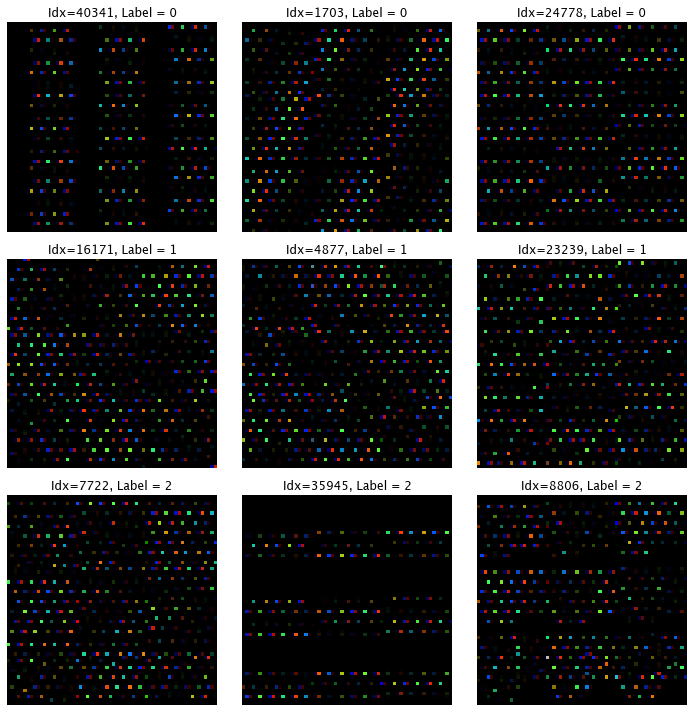

In [181]:
n = train_data.labels.shape[0]
R, C = len(np.unique(train_data.labels)), 3
fig, ax = plt.subplots(R, C, figsize = (10,10))

for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(train_data.labels == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis('off')
        idx = np.random.choice(label_x_rows)
        img = train_data.feature_vec[idx].reshape((64,64,3))
        y = train_data.labels[idx]
        plot_cell.imshow(img)
        plot_cell.set_title('Idx=%d, Label = %d' %(idx, label_class))

plt.tight_layout()
# img1 = train_data.feature_vec[idx1].reshape((64,64,3))
# img2 = train_data.feature_vec[idx2].reshape((64,64,3))
# img3 = train_data.feature_vec[idx3].reshape((64,64,3))
# print(train_data.labels[idx1], train_data.labels[idx2], train_data.labels[idx3])
# ax1.imshow(img1)
# ax2.imshow(img2)
# ax3.imshow(img3)
# plt.tight_layout()

In [183]:
from torch.utils.data import TensorDataset,DataLoader,Dataset 
from torch.optim import SGD, Adam
from torchsummary import summary
from torch_snippets import *
import torch
import torch.nn as nn

In [184]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.25),
        nn.Conv2d(ni, no, kernel_size=3, stride = 1, padding = 'same'),
        nn.LeakyReLU(negative_slope=0.2),
        nn.MaxPool2d(2)
    )

class DefectClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential( 
            convBlock(3, 32),
            convBlock(32, 64),
            convBlock(64, 64),
            
            nn.Flatten(),
            nn.Linear(8*8*64, R) ) 
    
        self.loss_fn = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
    

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    
    
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def test_batch(model, data, criterion):
    model.eval()
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [185]:
model = DefectClassification()
model.apply(initialize_weights)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-4)

In [186]:
summary(model, (3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Sequential: 2-1                   [-1, 32, 32, 32]          --
|    |    └─Dropout: 3-1                 [-1, 3, 64, 64]           --
|    |    └─Conv2d: 3-2                  [-1, 32, 64, 64]          896
|    |    └─LeakyReLU: 3-3               [-1, 32, 64, 64]          --
|    |    └─MaxPool2d: 3-4               [-1, 32, 32, 32]          --
|    └─Sequential: 2-2                   [-1, 64, 16, 16]          --
|    |    └─Dropout: 3-5                 [-1, 32, 32, 32]          --
|    |    └─Conv2d: 3-6                  [-1, 64, 32, 32]          18,496
|    |    └─LeakyReLU: 3-7               [-1, 64, 32, 32]          --
|    |    └─MaxPool2d: 3-8               [-1, 64, 16, 16]          --
|    └─Sequential: 2-3                   [-1, 64, 8, 8]            --
|    |    └─Dropout: 3-9                 [-1, 64, 16, 16]          --
|    |    

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Sequential: 2-1                   [-1, 32, 32, 32]          --
|    |    └─Dropout: 3-1                 [-1, 3, 64, 64]           --
|    |    └─Conv2d: 3-2                  [-1, 32, 64, 64]          896
|    |    └─LeakyReLU: 3-3               [-1, 32, 64, 64]          --
|    |    └─MaxPool2d: 3-4               [-1, 32, 32, 32]          --
|    └─Sequential: 2-2                   [-1, 64, 16, 16]          --
|    |    └─Dropout: 3-5                 [-1, 32, 32, 32]          --
|    |    └─Conv2d: 3-6                  [-1, 64, 32, 32]          18,496
|    |    └─LeakyReLU: 3-7               [-1, 64, 32, 32]          --
|    |    └─MaxPool2d: 3-8               [-1, 64, 16, 16]          --
|    └─Sequential: 2-3                   [-1, 64, 8, 8]            --
|    |    └─Dropout: 3-9                 [-1, 64, 16, 16]          --
|    |    

In [187]:
file_2H_1T = 'test_2H_1T.txt'
#2H and 1T data set
Natoms,ngrids,position,property,property2,tensor_tot= readfile(file_2H_1T)
print(tensor_tot.shape)
print("Total number of atoms: ", Natoms)

ngrids:  64 Natoms:  8400
total lines 1621200
(8400, 3, 64, 64)
Total number of atoms:  8400


In [188]:
print(list(property).count(0), list(property).count(1), list(property).count(2))

1640 6548 212


In [189]:
features={'data':tensor_tot}

with open('test_XX.p', 'wb') as infile:
    pickle.dump(features, infile, -1)


total_atoms = np.concatenate((position,property2),axis=1)
np.save("test_pos",total_atoms)
np.save("test_YY",property)
for keys in features:
    print(keys,features[keys].shape)

data (8400, 3, 64, 64)


In [190]:
test_data=readtraining_data("test_XX.p","test_YY.npy","test_pos.npy")

files to read:  test_XX.p test_YY.npy test_pos.npy
data (8400, 3, 64, 64)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
rr (8400, 64, 64, 3)
rr (8400, 4)
rr (8400,)


In [191]:
test_data.feature_vec = test_data.feature_vec.transpose((0,3,1,2)).astype('float')
print(test_data.feature_vec.shape, test_data.coordinate.shape)
print(test_data.coordinate[0])

(8400, 3, 64, 64) (8400, 4)
[3.5632  2.16205 6.608   1.     ]


In [192]:
l = test_data.labels.shape[0]
test_data.labels = test_data.labels.reshape((l))
test_data.labels.shape

(8400,)

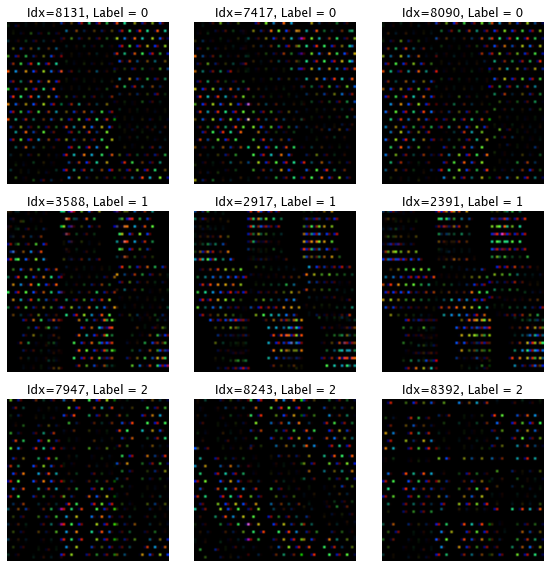

In [193]:
n = test_data.labels.shape[0]
R, C = len(np.unique(test_data.labels)), 3
fig, ax = plt.subplots(R, C, figsize = (8,8))

for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(test_data.labels == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis('off')
        idx = np.random.choice(label_x_rows)
        img = test_data.feature_vec[idx].reshape((64,64,3))
        y = test_data.labels[idx]
        plot_cell.imshow(img)
        plot_cell.set_title('Idx=%d, Label = %d' %(idx, label_class))

plt.tight_layout()

In [201]:
X_train = torch.tensor(train_data.feature_vec).float()
y_train = torch.tensor(train_data.labels, dtype = torch.int64)
print(X_train.shape, y_train.shape)
trn_dl = DataLoader(TensorDataset(X_train, y_train), 64, shuffle=True)

torch.Size([40426, 3, 64, 64]) torch.Size([40426])


In [219]:
from sklearn.model_selection import train_test_split

X_test = torch.tensor(test_data.feature_vec).float()
y_test = torch.tensor(test_data.labels, dtype = torch.int64)
print(X_test.shape, y_test.shape)

n = X_test.shape[0]
indices = np.arange(n)

(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X_test, y_test, indices, test_size=0.2)
print(n, len(indices_train), len(indices_test))

trn_dl = DataLoader(TensorDataset(X_train, y_train), 64, shuffle=True)
test_dl = DataLoader(TensorDataset(X_test, y_test), 64, shuffle=True)

torch.Size([8400, 3, 64, 64]) torch.Size([8400])
8400 6720 1680


EPOCH: 1.000	trn_loss: 0.338	trn_acc: 0.953	test_loss: 0.101	test_acc: 0.973	(6.90s - 683.58s remaining)
EPOCH: 2.000	trn_loss: 0.092	trn_acc: 0.978	test_loss: 0.078	test_acc: 0.981	(13.70s - 671.12s remaining)
EPOCH: 3.000	trn_loss: 0.074	trn_acc: 0.979	test_loss: 0.065	test_acc: 0.983	(20.49s - 662.65s remaining)
EPOCH: 4.000	trn_loss: 0.058	trn_acc: 0.982	test_loss: 0.076	test_acc: 0.975	(27.30s - 655.09s remaining)
EPOCH: 5.000	trn_loss: 0.054	trn_acc: 0.981	test_loss: 0.159	test_acc: 0.968	(34.17s - 649.27s remaining)
EPOCH: 6.000	trn_loss: 0.049	trn_acc: 0.984	test_loss: 0.062	test_acc: 0.983	(40.96s - 641.64s remaining)
EPOCH: 7.000	trn_loss: 0.053	trn_acc: 0.982	test_loss: 0.060	test_acc: 0.984	(47.87s - 635.96s remaining)
EPOCH: 8.000	trn_loss: 0.041	trn_acc: 0.986	test_loss: 0.063	test_acc: 0.981	(54.85s - 630.73s remaining)
EPOCH: 9.000	trn_loss: 0.042	trn_acc: 0.985	test_loss: 0.075	test_acc: 0.978	(61.66s - 623.49s remaining)
EPOCH: 10.000	trn_loss: 0.035	trn_acc: 0.988	te

EPOCH: 77.000	trn_loss: 0.003	trn_acc: 1.000	test_loss: 0.057	test_acc: 0.986	(531.17s - 158.66s remaining)
EPOCH: 78.000	trn_loss: 0.003	trn_acc: 1.000	test_loss: 0.058	test_acc: 0.986	(538.08s - 151.77s remaining)
EPOCH: 79.000	trn_loss: 0.003	trn_acc: 1.000	test_loss: 0.077	test_acc: 0.983	(545.26s - 144.94s remaining)
EPOCH: 80.000	trn_loss: 0.003	trn_acc: 1.000	test_loss: 0.058	test_acc: 0.983	(552.55s - 138.14s remaining)
EPOCH: 81.000	trn_loss: 0.003	trn_acc: 1.000	test_loss: 0.054	test_acc: 0.987	(559.46s - 131.23s remaining)
EPOCH: 82.000	trn_loss: 0.002	trn_acc: 1.000	test_loss: 0.070	test_acc: 0.980	(566.34s - 124.32s remaining)
EPOCH: 83.000	trn_loss: 0.002	trn_acc: 1.000	test_loss: 0.060	test_acc: 0.986	(573.22s - 117.41s remaining)
EPOCH: 84.000	trn_loss: 0.002	trn_acc: 1.000	test_loss: 0.058	test_acc: 0.987	(580.11s - 110.50s remaining)
EPOCH: 85.000	trn_loss: 0.002	trn_acc: 1.000	test_loss: 0.073	test_acc: 0.982	(587.17s - 103.62s remaining)
EPOCH: 86.000	trn_loss: 0.00

100%|████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 547.41it/s]


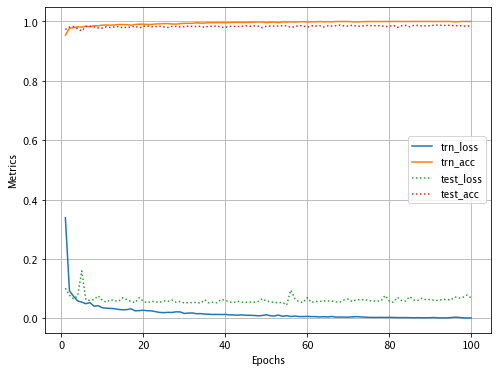

2022-02-24 17:44:00.867 | INFO     | __main__:<module>:19 - Dumped object of size ≈619 KB @ "no-aug-no-bn.log" in 2.04e-01 seconds


In [220]:
n_epochs = 20
log = Report(n_epochs)

for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
    
    
    N = len(test_dl)
    for bx, data in enumerate(test_dl):
        loss, acc = test_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, test_loss=loss, test_acc=acc, end='\r')
    
    log.report_avgs(ex+1)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

In [222]:
natoms = test_data.feature_vec.shape[0]
natoms
x = torch.tensor(test_data.feature_vec[0][None]).float()
x.shape

torch.Size([1, 3, 64, 64])

In [223]:
test_data.coordinate.shape

(8400, 4)

In [224]:
# Generate labels from trained model and write them in a file
fileName = 'Mo_labelled_from_CNN.xyz'
fh = open(fileName, 'w')
natoms = test_data.coordinate.shape[0]
fh.write('%d\n\n' %natoms)

for i in range(natoms):
    x = torch.tensor(test_data.feature_vec[i][None]).float()
    pred = torch.max(model(x), 1)[1]
    true = test_data.labels[i]
    x, y, z, aty = test_data.coordinate[i]
    fh.write('%d %12.6f %12.6f %12.6f %d %d\n' %(aty, x, y, z, pred, true))
    #print(pred, true)

fh.close()

In [225]:
print(list(test_data.labels).count(0), list(test_data.labels).count(1), list(test_data.labels).count(2))

1640 6548 212
